In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [3]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data = np.array(df)
np.random.shuffle(data)

# No transpose here
Y = data[:, 0].astype(int)
X = data[:, 1:] / 255.0  # normalize pixels

# Split
X_dev = X[:1000].T          # shape (784, 1000)
Y_dev = Y[:1000]

X_train = X[1000:].T        # shape (784, m-1000)
Y_train = Y[1000:]


In [5]:
# Each weight is 10x784 because each column is a pixel and there are 10 rows because
# there are the possible outputs are 0-9

def init_params():
    # Using Kaiming He initialization of weights which draws from a normal distribution where
    # mean is 0 and standard deviation is square root of 2/n where n is number of features
    mean = 0.0
    features = 784
    nodes = 10
    stddev = np.sqrt(2.0/features)
    
    W1 = np.random.normal(mean, stddev, (nodes, features))
    b1 = np.zeros((10, 1))
    stddev_W2 = np.sqrt(2.0 / 10.0)
    W2 = np.random.normal(0, stddev_W2, (10, 10))
    b2 = np.zeros((10, 1))

    return W1, b1, W2, b2

In [6]:
# Activation function of hidden layer, A = Z if Z > 0 else alpha*Z
def leaky_ReLU(Z):
    alpha = 0.01
    return np.where(Z > 0, Z, alpha * Z)

# Activation function of output layer
def softMax(Z):
    Z_shifted = Z - np.max(Z, axis=0, keepdims=True)  # subtract max per column
    exp_Z = np.exp(Z_shifted)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = leaky_ReLU(Z1)

    Z2 = W2.dot(A1) + b2
    A2 = softMax(Z2)

    return Z1, A1, Z2, A2

In [7]:
# Converts Y into the dimensions that we want (0s in each row and 1 in the row for that digit)
def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

# Derivative of leaky ReLU activation function, 1 if Z > 0, 0 otherwise
def deriv_leaky_ReLU(Z):
    alpha = 0.01
    return np.where(Z > 0, 1, alpha)
    
def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = (1/m) * dZ2.dot(A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T.dot(dZ2) * deriv_leaky_ReLU(Z1)
    dW1 = (1/m) * dZ1.dot(X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    # L2 regularization
    lambda_reg = 0.0005
    dW1 += (lambda_reg / m) * W1
    dW2 += (lambda_reg / m) * W2

    return dW1, db1, dW2, db2

In [8]:
def update_params(W1, b1, W2, b2,
                  dW1, db1, dW2, db2,
                  vW1, vb1, vW2, vb2,
                  alpha=0.1, beta=0.9):

    vW1 = beta * vW1 + (1 - beta) * dW1
    vb1 = beta * vb1 + (1 - beta) * db1
    vW2 = beta * vW2 + (1 - beta) * dW2
    vb2 = beta * vb2 + (1 - beta) * db2

    W1 -= alpha * vW1
    b1 -= alpha * vb1
    W2 -= alpha * vW2
    b2 -= alpha * vb2

    return W1, b1, W2, b2, vW1, vb1, vW2, vb2


In [9]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations):
    W1, b1, W2, b2 = init_params()
    vW1 = np.zeros_like(W1)
    vb1 = np.zeros_like(b1)
    vW2 = np.zeros_like(W2)
    vb2 = np.zeros_like(b2)

    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2, vW1, vb1, vW2, vb2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, vW1, vb1, vW2, vb2)

        if i % 10 == 0:
            print("Iteration: ", i)
            print("Accuracy: ", get_accuracy(get_predictions(A2), Y))

    return W1, b1, W2, b2

In [10]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 1000)

Iteration:  0
[5 2 6 ... 5 5 4] [6 9 1 ... 0 0 7]
Accuracy:  0.13134146341463415
Iteration:  10
[2 2 1 ... 0 0 4] [6 9 1 ... 0 0 7]
Accuracy:  0.30617073170731707
Iteration:  20
[2 2 1 ... 0 0 4] [6 9 1 ... 0 0 7]
Accuracy:  0.4594390243902439
Iteration:  30
[2 9 1 ... 0 0 9] [6 9 1 ... 0 0 7]
Accuracy:  0.5634146341463414
Iteration:  40
[2 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.6492682926829269
Iteration:  50
[2 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.7294390243902439
Iteration:  60
[2 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.7619024390243903
Iteration:  70
[2 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.7783414634146342
Iteration:  80
[6 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.7967560975609757
Iteration:  90
[6 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.8099512195121952
Iteration:  100
[6 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.819
Iteration:  110
[6 9 1 ... 0 0 7] [6 9 1 ... 0 0 7]
Accuracy:  0.8274146341463414
Iteration:  120
[6 9 1 ... 0 0 7] [6 9

In [11]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_predictions(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [1]
Label:  1


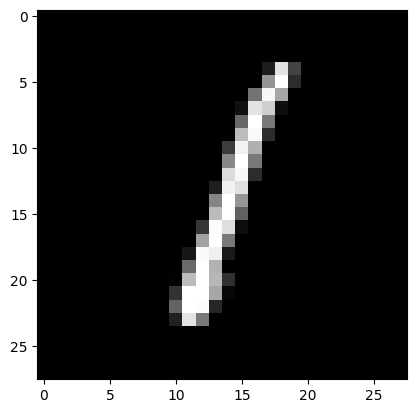

In [12]:
import time
test_predictions(7, W1, b1, W2, b2)
#for i in range(1000):
    #test_predictions(i, W1, b1, W2, b2)
    #time.sleep(3)

In [13]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[5 2 3 5 9 8 3 4 4 0 8 5 0 1 3 0 1 9 5 8 3 2 7 6 4 2 3 9 2 2 4 2 1 6 8 3 1
 1 6 5 5 7 3 5 2 6 8 2 7 4 3 3 0 0 8 1 0 3 6 1 1 0 7 2 8 5 0 0 6 7 7 3 0 2
 2 2 3 7 4 8 2 4 9 4 9 7 0 0 8 9 7 0 6 5 9 7 1 2 3 2 6 0 2 8 6 4 5 0 4 6 9
 3 5 6 0 1 2 4 5 1 6 1 0 5 4 2 3 1 3 8 8 0 1 8 4 4 6 0 6 6 9 9 9 2 0 8 3 5
 4 3 4 3 8 2 3 4 3 8 7 0 8 9 3 4 0 1 3 6 3 4 7 6 2 3 0 5 5 6 9 8 0 9 9 6 1
 5 3 2 7 0 4 3 3 0 6 2 6 8 8 1 2 1 3 4 0 7 7 2 1 3 9 5 3 2 8 1 5 9 6 9 9 0
 8 8 7 4 5 4 5 1 1 1 7 1 1 6 4 4 6 0 5 1 1 0 0 3 3 0 6 0 2 0 5 2 1 9 0 2 5
 0 7 8 7 6 0 6 6 9 2 6 2 5 6 3 8 6 7 8 1 2 8 4 6 6 4 2 2 4 6 7 0 6 4 8 2 1
 0 9 0 8 5 5 1 2 9 0 3 6 1 0 6 0 1 2 7 8 3 9 0 9 1 0 8 9 7 7 8 7 5 2 4 7 7
 2 1 5 4 6 1 4 5 6 3 4 4 4 2 5 1 2 4 9 9 7 1 5 6 1 4 2 0 6 5 1 6 2 6 9 6 7
 7 8 7 2 6 9 0 8 8 2 0 7 0 1 6 1 1 9 1 8 7 6 3 4 0 3 1 5 2 4 3 2 4 4 6 9 2
 3 3 2 5 4 5 1 7 5 0 0 9 8 0 8 4 6 2 7 5 1 0 1 0 6 3 0 4 2 9 2 1 3 5 5 2 3
 4 2 9 3 0 7 8 5 7 7 3 8 4 2 6 1 3 6 1 5 6 1 6 5 8 9 7 2 8 9 0 1 8 7 0 3 9
 0 8 9 9 4 8 9 6 5 4 1 1 

0.913

In [14]:
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_data = np.array(test_df)
np.random.shuffle(test_data)

X_test = (test_data.T) / 255.0

test_predictions = make_predictions(X_test, W1, b1, W2, b2)